In [422]:
import os
import pandas as pd
from tensorflow import keras
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Dense, Lambda, Activation, LSTM
from tensorflow.keras.optimizers import Adam, RMSprop
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

In [423]:
# !wget -q https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
# !unzip -q jena_climate_2009_2016.csv.zip

In [424]:
file = os.path.join('jena_climate_2009_2016.csv')
file_df = pd.read_csv(file)
DF = file_df.iloc[:, 1:] # Todas las filas de la columna 1 en adelante



1.   Genera secuencias x para entrenamiento (50%), validación (25%) y prueba (25%) de 120 elementos de longitud a partir de los datos de temperatura.



In [425]:
# Es necesario normalizar los datos
from sklearn.preprocessing import MinMaxScaler

df = DF.copy()

scaler = MinMaxScaler(feature_range = (-1, 1))
df[df.columns] = scaler.fit_transform(df[df.columns])

/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasatt

In [426]:
DF

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,996.52,-8.02,265.40,-8.90,93.30,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,996.57,-8.41,265.01,-9.28,93.40,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,996.53,-8.51,264.91,-9.31,93.90,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,996.51,-8.31,265.12,-9.07,94.20,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,996.51,-8.27,265.15,-9.04,94.10,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
420446,1000.07,-4.05,269.10,-8.13,73.10,4.52,3.30,1.22,2.06,3.30,1292.98,0.67,1.52,240.0
420447,999.93,-3.35,269.81,-8.06,69.71,4.77,3.32,1.44,2.07,3.32,1289.44,1.14,1.92,234.3
420448,999.82,-3.16,270.01,-8.21,67.91,4.84,3.28,1.55,2.05,3.28,1288.39,1.08,2.00,215.2
420449,999.81,-4.23,268.94,-8.53,71.80,4.46,3.20,1.26,1.99,3.20,1293.56,1.49,2.16,225.8


In [427]:
df

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,0.629877,-0.502737,-0.512677,-0.330424,0.846065,-0.924228,-0.831457,-0.990437,-0.836642,-0.834404,0.486426,-0.859193,-0.851064,-0.153889
1,0.630860,-0.515674,-0.525519,-0.346218,0.848363,-0.927412,-0.837995,-0.990872,-0.842314,-0.840828,0.498698,-0.901572,-0.872340,-0.243889
2,0.630074,-0.518992,-0.528811,-0.347465,0.859851,-0.928048,-0.838721,-0.991306,-0.843449,-0.841542,0.501332,-0.974026,-0.946383,-0.046667
3,0.629681,-0.512357,-0.521897,-0.337490,0.866743,-0.926457,-0.834363,-0.991741,-0.838911,-0.837259,0.495046,-0.953520,-0.957447,0.100000
4,0.629681,-0.511030,-0.520909,-0.336243,0.864446,-0.926138,-0.833636,-0.991741,-0.838911,-0.836545,0.493909,-0.956254,-0.946383,0.190556
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
420446,0.699656,-0.371040,-0.390846,-0.298421,0.381964,-0.886342,-0.817653,-0.946968,-0.823029,-0.821556,0.398007,-0.908407,-0.870638,0.333333
420447,0.696904,-0.347819,-0.367468,-0.295511,0.304078,-0.878383,-0.816201,-0.937405,-0.821894,-0.820128,0.376815,-0.844156,-0.836596,0.301667
420448,0.694742,-0.341516,-0.360882,-0.301746,0.262723,-0.876154,-0.819106,-0.932623,-0.824163,-0.822984,0.370529,-0.852358,-0.829787,0.195556
420449,0.694545,-0.377011,-0.396115,-0.315046,0.352096,-0.888252,-0.824918,-0.945229,-0.830970,-0.828694,0.401479,-0.796309,-0.816170,0.254444


In [485]:
train_dataset = keras.utils.timeseries_dataset_from_array(
    data = df.iloc[0:210226, 1][:-120],
    targets = df.iloc[0:210226,1][120:],
    sequence_length = 120,
    sampling_rate = 6, # Se toma un dato cada 6 datos (cada hora)
    batch_size = 128,
    shuffle = True
)

val_dataset = keras.utils.timeseries_dataset_from_array(
    data = df.iloc[210226:315339, 1][:-120],
    targets = df.iloc[210226:315339, 1][120:],
    sequence_length = 120,
    sampling_rate = 6,
    batch_size = 128,
    shuffle = True
)

test_dataset = keras.utils.timeseries_dataset_from_array(
    data = df.iloc[315339: , 1],
    targets = df.iloc[315339: ,1],
    sequence_length = 120,
    sampling_rate = 6,
    batch_size = 128,
    shuffle = False
)

2. Construye y entrena una red que estime la temperatura 10 pasos en el futuro. Puedes usar tanto Conv1D o bien LSTM

In [429]:
model = Sequential()

model.add(LSTM(128, input_shape = (None, 1)))
model.add(Dense(1))

In [430]:
model.compile(
    optimizer = 'Adam',
    loss = 'mean_squared_error',
    metrics = ['mse', 'mae']
)

history = model.fit(
    train_dataset,
    epochs = 100,
    validation_data = val_dataset
)

Epoch 1/100
1636/1636 [==============================] - 30s 17ms/step - loss: 0.0082 - mse: 0.0082 - mae: 0.0647 - val_loss: 0.0017 - val_mse: 0.0017 - val_mae: 0.0332
Epoch 2/100
1636/1636 [==============================] - 28s 17ms/step - loss: 0.0014 - mse: 0.0014 - mae: 0.0289 - val_loss: 6.7400e-04 - val_mse: 6.7400e-04 - val_mae: 0.0195
Epoch 3/100
1636/1636 [==============================] - 28s 17ms/step - loss: 7.7105e-04 - mse: 7.7105e-04 - mae: 0.0211 - val_loss: 3.6641e-04 - val_mse: 3.6641e-04 - val_mae: 0.0137
Epoch 4/100
1636/1636 [==============================] - 28s 17ms/step - loss: 5.4008e-04 - mse: 5.4008e-04 - mae: 0.0174 - val_loss: 5.7381e-04 - val_mse: 5.7381e-04 - val_mae: 0.0188
Epoch 5/100
1636/1636 [==============================] - 28s 17ms/step - loss: 0.0169 - mse: 0.0169 - mae: 0.0828 - val_loss: 0.0239 - val_mse: 0.0239 - val_mae: 0.1227
Epoch 6/100
1636/1636 [==============================] - 28s 17ms/step - loss: 0.0111 - mse: 0.0111 - mae: 0.0794 -

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



1636/1636 [==============================] - 27s 17ms/step - loss: 4.7808e-04 - mse: 4.7808e-04 - mae: 0.0087 - val_loss: 1.3180e-05 - val_mse: 1.3180e-05 - val_mae: 0.0028
Epoch 43/100
1636/1636 [==============================] - 27s 16ms/step - loss: 2.2707e-04 - mse: 2.2707e-04 - mae: 0.0057 - val_loss: 9.6498e-06 - val_mse: 9.6498e-06 - val_mae: 0.0023
Epoch 44/100
1636/1636 [==============================] - 27s 16ms/step - loss: 2.5444e-05 - mse: 2.5444e-05 - mae: 0.0036 - val_loss: 2.7246e-06 - val_mse: 2.7246e-06 - val_mae: 9.9307e-04
Epoch 47/100
1636/1636 [==============================] - 27s 16ms/step - loss: 3.8143e-05 - mse: 3.8143e-05 - mae: 0.0036 - val_loss: 7.8708e-06 - val_mse: 7.8708e-06 - val_mae: 0.0022
Epoch 48/100
1636/1636 [==============================] - 27s 16ms/step - loss: 3.8117e-05 - mse: 3.8117e-05 - mae: 0.0034 - val_loss: 2.6397e-06 - val_mse: 2.6397e-06 - val_mae: 0.0012
Epoch 49/100
1636/1636 [==============================] - 27s 17ms/step - loss:

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



1636/1636 [==============================] - 26s 16ms/step - loss: 5.1297e-06 - mse: 5.1297e-06 - mae: 0.0016 - val_loss: 1.7075e-06 - val_mse: 1.7075e-06 - val_mae: 9.9834e-04
Epoch 73/100
1636/1636 [==============================] - 27s 16ms/step - loss: 4.7450e-06 - mse: 4.7450e-06 - mae: 0.0015 - val_loss: 1.0589e-06 - val_mse: 1.0589e-06 - val_mae: 8.3649e-04
Epoch 74/100
1636/1636 [==============================] - 27s 16ms/step - loss: 4.9897e-06 - mse: 4.9897e-06 - mae: 0.0016 - val_loss: 9.7940e-06 - val_mse: 9.7940e-06 - val_mae: 0.0029
Epoch 75/100
1636/1636 [==============================] - 27s 16ms/step - loss: 5.8509e-06 - mse: 5.8509e-06 - mae: 0.0017 - val_loss: 9.7372e-07 - val_mse: 9.7372e-07 - val_mae: 6.3598e-04
Epoch 76/100
1636/1636 [==============================] - 27s 17ms/step - loss: 4.1081e-06 - mse: 4.1081e-06 - mae: 0.0014 - val_loss: 2.3221e-06 - val_mse: 2.3221e-06 - val_mae: 0.0011
Epoch 77/100
1636/1636 [==============================] - 27s 16ms/step

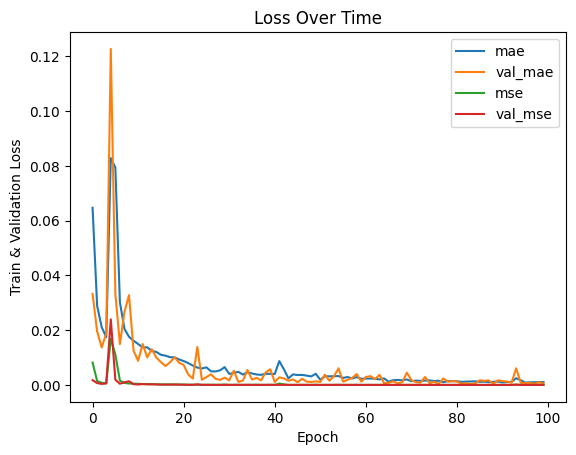

In [509]:
plt.plot(history.history['mae'], label = 'mae')
plt.plot(history.history['val_mae'], label = 'val_mae')
plt.plot(history.history['mse'], label = 'mse')
plt.plot(history.history['val_mse'], label = 'val_mse')
plt.legend()

plt.xlabel('Epoch')
plt.ylabel('Train & Validation Loss')
plt.title('Loss Over Time')
plt.savefig('LossOverTime.png')
plt.show()

In [510]:
predicts = model.predict(test_dataset)

816/816 [==============================] - 9s 11ms/step


In [511]:
predicts_index = [[i+315339, predicts[i][0]] for i in range(len(predicts))]
x = [i[0] for i in predicts_index]
y = [j[1] for j in predicts_index]

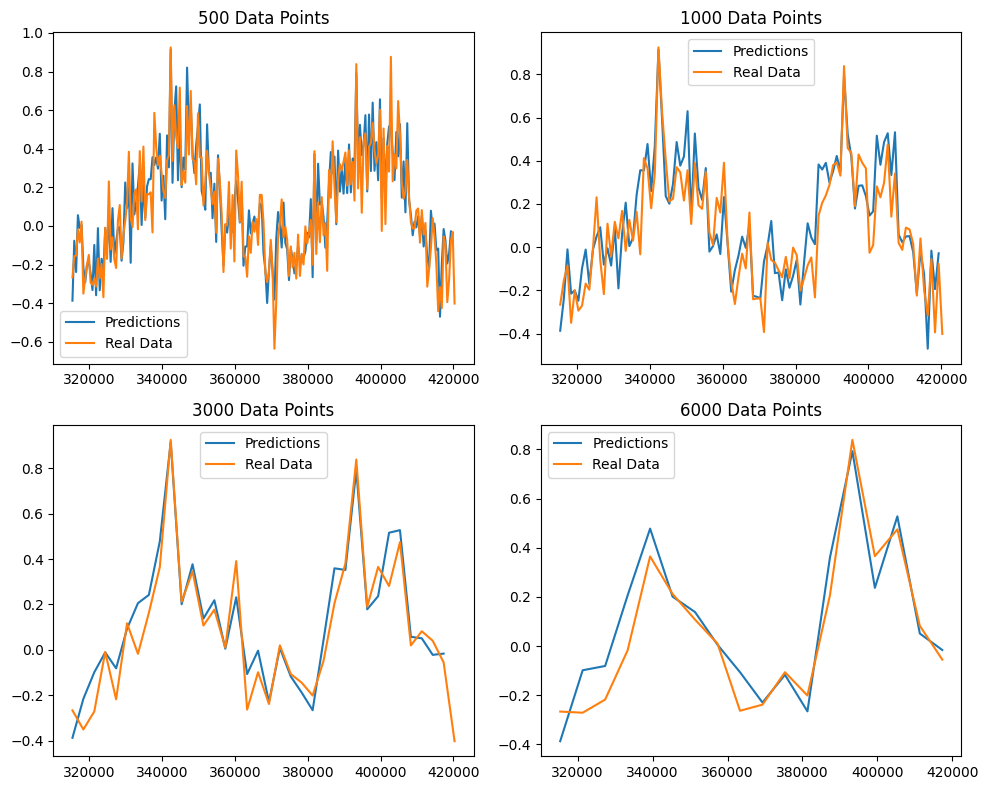

In [530]:
import matplotlib.pyplot as plt

# Crear una figura con cuatro subgráficas
fig, axs = plt.subplots(2, 2, figsize=(10, 8))

# Gráfico con 500 puntos
axs[0, 0].plot(x[::500], y[::500], label='Predictions')
axs[0, 0].plot(df.iloc[315339:, 1][::500], label='Real Data')
axs[0, 0].legend()
axs[0, 0].set_title('500 Data Points')

# Gráfico con 1000 puntos
axs[0, 1].plot(x[::1000], y[::1000], label='Predictions')
axs[0, 1].plot(df.iloc[315339:, 1][::1000], label='Real Data')
axs[0, 1].legend()
axs[0, 1].set_title('1000 Data Points')

# Gráfico con 3000 puntos
axs[1, 0].plot(x[::3000], y[::3000], label='Predictions')
axs[1, 0].plot(df.iloc[315339:, 1][::3000], label='Real Data')
axs[1, 0].legend()
axs[1, 0].set_title('3000 Data Points')

# Gráfico con 6000 puntos
axs[1, 1].plot(x[::6000], y[::6000], label='Predictions')
axs[1, 1].plot(df.iloc[315339:, 1][::6000], label='Real Data')
axs[1, 1].legend()
axs[1, 1].set_title('6000 Data Points')

# Ajustar el diseño y guardar la figura
plt.tight_layout()
plt.savefig('cuatro_subgraficas.png')
plt.show()

In [617]:
# Se busca predecir una secuencia futura dado una predicción ya realizada
def predict_sequence(input_sequence, model, pred_steps):

    history_sequence = input_sequence.copy()    # Se copia la secuencia de entrada
    pred_sequence = np.zeros((1, pred_steps * 120, 1))     # Matríz de ceros para almacenar las predicciones futuras
                                                                  # Cuántas veces el conjunto de predicciones hechas se va a repetir para generar nuevas
    for i in range(pred_steps):
        # Dos partes
        # 1) Se usa el model.predict para hacer las primeras predicciones usando la sequencia de entrada
        # 2) Como en los modelos siempre el index es [batch, filas, columnas]
        #   2.1) [0] -> representa el primer batch
        #   2.2) [-120: ] -> toma los últimos elementos (fila)
        #   2.3) [0] -> toma el primer valor (columna)
        last_step_pred = model.predict(history_sequence)[0, -120: , 0]
        pred_sequence[0, (i * 120) : ((i+1) * 120), 0] = last_step_pred   # Se guardan las predicciones en la matriz de ceros

        # Agrega las predicciones TAMBIÉN a history_seuqence para realizar más predicciones
        history_sequence = np.concatenate(
            [history_sequence, last_step_pred.reshape(-1, 120, 1)],
            axis = 1
            )

    return pred_sequence

In [618]:
pred_steps = 10
preds = predict_sequence(predicts, model, pred_steps)  # Predicciones hechas a partir de la data generada

3263/3263 [==============================] - 6s 2ms/step


IndexError: too many indices for array: array is 2-dimensional, but 3 were indexed